<a href="https://colab.research.google.com/github/hyeonji0401/CUDA_practice/blob/main/CUDA_sharedMemory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 9.1 공유 메모리 사용 방법
- 크게 다음 3가지로 구분할 수 있음
  - 스레드 블록 내 스레드들의 공유 데이터 보관
  - L1 캐시(HW 관리 캐시)
  - 사용자 관리(user-managed) 캐시

1.스레드 블록 내 스레드들의 공유 데이터 보관
- 만약 블록 내 스레드들 사이에 정보 또는 데이터를 주고 받아야한다면 공유 메모리에 변수 등 공간을 만들고 여러 스레드들이 해당 공간에 데이터를 읽고 쓰는 형태로 구현 가능함
- 동기화를 주의해야함
  - 공유 메모리는 여러 스레드가 동시에 데이터를 쓰거나 읽을 수 있기 때문에 읽고 쓰는 순서에 대한 약속을 지켜야함
  - 동기화란 스레드들 사이에 순서를 맞추는 행위 또는 서로 정보를 교환하는 행위라고 말할 수 있음
  - 볼록 내 스레드들에 대한 동기화함수는 _syncthreads()
    - 블록 내 모든 스레드가 해당 지점에 도착할 때까지 다른 스레드들의 진행을 막는 역할을 함

2.L1캐시(HW 관리 캐시)
- 스레드들이 공유하는 데이터를 판단하기 어렵고, 자주 사용하는 데이터에 대한 분류 및 관리를 직접 하기 어려운 경우 간단히 사용할 수 있는 방법
- 공유 메모리를 L1 캐시로 사용하면 일반적인 캐시와 유사한 형태로 동작함

**캐시의 동작원리**

> - 캐시는 일반적으로 코어 내부에 있는 메모리를 말함
- 시스템 메모리에 대해 입출력 병목 현상을 해소하는 역할을 함
- 크기가 매우 작지만 캐시가 입출력 병목 현상에 도움이 되는 이유는 지역성 때문
 - 대표적 예시는 for문

- GPU의 캐시 또한 CPU 캐시와 유사하게 동작함
- 그러나 GPU는 SIMT의 구조를 가지므로 32개의 스레드가 동시에 접근함
  - 따라서 워프 내 스레드들의 메모리 접근 패턴에 따라 성능이 크게 달라질 수 있음
- 워프 내 스레드들이 한 번에 접근하는 데이터 블록의 수가 메모리 접근 횟수가 됨
  - 이상적인 경우 : 1번 / 최악의 경우 : 32번
- 따라서 워프 내 스레드들이 동일한 또는 인접한 데이터에 접근하도록 스레드 레이아웃 및 알고리즘을 설계하면 그렇지 않은 경우 대비 큰 성능 향상을 기대할 수 있음

3.사용자 관리 캐시
- L1캐시는 HW가 관리하기 때문에 알고리즘의 특징을 반영한 최적의 캐시 활용 효율이 얻기 어려움
- 사용자 관리 캐시란 알고리즘의 특성을 기반으로 데이터 접근 패턴을 파악하고 그에 따라 사용자가 직접 목표 데이터를 공유 메모리 영역으로 가져오거나 내리면서 공유 메모리는 캐시처럼 사용하는 것을 말함

# 9.2 공유 메모리 사용 에제 - 1024보다 작은 행렬의 곱셈

- 공유 메모리 사용 전 코드


```
__global__ void matMul_kernel(float * _A, float* _B, float* _C)
{
  int row = threadIdx.x;
  int col = threadIdx.y;
  int index = row*blockDim.y +col;
  float result =0;
  for(int k=0; k< K_SIZE; k++)
    result+=+A[row * K_SIZE +K] * _B[col+k*COL_SIZE];
  _C[index] = result;
}
```
**어떤 데이터를 메모리에 올릴 것인가?**
- 공유 메모리를 사용자 성의 캐시로 사용하는 전략의 핵심은 블록 내 스레드들이 자주 접근하는 데이터를 공유 메모리에 가져다 놓음으로써, 전역 메모리(디바이스 메모리 영역) 접근 수를 줄이는 것임

- 입력 행렬 A와 B는 각 COL_SIZE번, ROW_SIZE번씩 접근하게 됨
- 행렬 C는 결과를 쓰기 위해 한 번씩만 접근하면 됨
- **공유 메모리 사용 안할 시 총 접근 횟수**


> 2*(ROW_SIZE*COL_SIZE*K_SIZE) + (ROW_SIZE* COL_SIZE)

> (2*K_SIZE+1)*(ROW_SIZE*COL_SIZE)
> O(ROW_SIZE*COL_SIZE*KSIZE)

- 행렬 A,B 원소들은 반복해서 접근하므로 공유 메모리에 올려 놓으면 전역 메모리 접근 횟수를 줄일 수 있음

**공유 메모리에 올릴 수 있는 크기인가?**
- 만약 ROW_SIZE , COL_SIZE = 32, K_SIZE = 128일 경우
= 행렬 A, B의 크기는 16kb(4096*4byte)
- CUDA를 지원하는 대부분의 GPU는 48kb보다 큰 공유 메모리를 가지고 있음

- **공유 메모리 사용 시 총 접근 횟수**
> (ROW_SIZE* K_SIZE) + (K_SIZE*COL_SIZE) +(ROW_SIZE * COL_SIZE)
> = K_SIZE * (ROW_SIZE + COL_SIZE) +ROW_SIZE * COL_SIZE
>O(K_SIZE*(ROW_SIZE+COL_SIZE)

- 공유 메모리를 사용하지 않는 경우 대비 전역 메모리에 대한 접근 횟수를 약 1/ROW_SIZE 또는 1/COL_SIZE수준으로 크게 감소시켰음


[행렬 곱셈 커널 - 공유 메모리 사용]


```
__global__ void matMul_kernel_shared(float* _A, float* _B, float* _C){
  int row = threadIdx.x;
  int col = threadidx.y;
  int index = row * blockDim.y + col;

  __shared__ float sA[ROW_SIZE][K_SIZE];
  __shared__ flost sB[K_SIZE][COL_SIZE];

  if(row==0){
    for(int k=0; k<K_SIZE; k++)
      sB[k][col] = _B[col+k*COL_SIZE];
  }
  if(col==0){
    for(int k=0; k<K_SIZE; k++)
      sA[row][k] = _A[row*K_SIZE+k];
  }

  float result =0;
  for(int k=0; k<K_SIZE; k++)
      result +=sA[row][k] * sB[k][col];
  _C[index] = result;

```



- 공융 메모리를 사용하려면 먼저 공유 메모리 영역에 공간을 할당 받아야함
  - __shared__ 키워드를 이용해서 정적 할당 방식으로 메모리 할당
- 전역 메모리에서 공유 메모리로 데이터를 복사해야함
  - 공유 메모리 공간은 블록 내 모든 스레드가 공유하므로 하나의 스레드가 데이터를 복사하더라도 다른 스레드들도 접근해서 사용할 수 있음
  - 대표 스레드(master thread) 하나가 복사를 전담하는 방법을 사용할 수 있음



```
if(threadIdx.x==0 && threadIdx.y==0){
  for(int r=0; k<ROW_SIZE; k++)
    for(int k=0; k<K_SIZE; k++){
       sA[r][k] = _A[r*K_SIZE +k];
    }
  
  for(int c=0; k<COL_SIZE; k++)
     for(int k=0; k<K_SIZE; k++){
        sB[k][c] = _B[c+k+COL_SIZE];
     }
}
__syncthreads();
```

- 대표 스레드가 데이터 복사를 전담하는 경우 다른 스레드들은 대표 스레드가 작업을 마칠 때까지 아무 일도 하지 않고 대기해야함



- 대표 메모리보다는 되도록 많은 스레드가 데이터 복사 작업에 참여하는 것이 효율적임
  - 이를 위해 각 스레드가 어떤 부분을 담당할지 결정해야함
  - 본 실습에서는 스레드 레이아웃을 활용함
     - 각 스레드가 자신이 담당한느 원소를 게산하기 위해 필요한 데이터를 복사하는 작업에 참여하도록 함
     - 각 스레드가 A의 row번째 행과 B의 col번째 열을 복사하도록함
        - 데이터 중복 복사 발생
        - 이를 방지하기 위해서는 동일 행 또는 동일 열을 처리하는 스레드들을 복사 작업에서 배제해야함

- 행렬 B는 col을 기준으로 데이터를 복사하며 각 열에서 하나의 스레드만 데이터 복사에 참여


```
if(row==0){
  for(int k=0; k<K_SIZE; k++)
    sB[k][col] = _B[col+k*COL_SIZE];
}
```

- 행렬 A는 row를 기준으로 데이터를 복사하여 각 행에서 하나의 스레드만 데이터 복사에 참여


```
if(col==0)
  for(int k=0; k<COL_SIZE; k++){
     sA[row][k] = _A[row*K_SIZE + k];
```

- 행렬 A,B를 공유 메모리로 옮겨놓은 다음 공유 메모리에 있는 데이터로 연산을 수행하면 되는데 그 전에 다 옮겨졌는지 확인이 필요함
  - 모든 스레드의 발을 맞추는 동기화 작업이 필요함
  - __syncthreads()를 통해 블록 내 스레드들을 동기화시킬 수 있음
  - 동기화 함수를 제거하면 결과가 잘못나오는 것을 확인할 수 있음





**성능비교**

- 공유 메모리 안쓴 코드 실행 시간

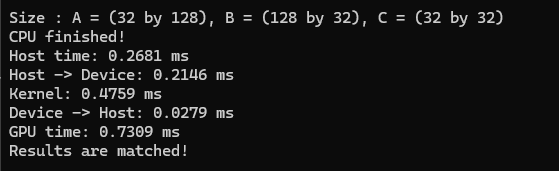

- 공유 메모리 사용한 코드 실행 시간

........더 느리다 다시 코드 작성해봐야겟다,,,,,,,,,이상하다,,,,,,,,,